# Livelike Basic Usage Demo: Tract/Supertract

- ACS 2019 - 2023 5-Year Estimates
- UP Baseline Constraints: employment, industry, occupation, education
- Knoxville City Central, TN PUMA (`4701501`)

## Setup

In [1]:
%load_ext watermark
%watermark

Last updated: 2025-03-20T14:44:44.875112-04:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [2]:
import pathlib

import geopandas as gpd
import numpy as np
import pandas as pd
from likeness_vitals.vitals import get_censusapikey, match
from pymedm import PMEDM, diagnostics

from livelike import acs, est, homesim

%watermark -w
%watermark -iv

Watermark: 2.5.0

likeness_vitals: 0.1.dev3+g2392110.d20250320
geopandas      : 1.0.1
pymedm         : 2.2.3
livelike       : 1.4.8.dev3+geea70e8
pandas         : 2.2.3
numpy          : 2.2.4



### Read Census API Key

In [3]:
key = get_censusapikey(pathlib.Path("..", ""))

### Create baseline PUMA representation

The `puma` class stores a representation of the PUMA based on ACS constraints. It contains the microdata and block group/tract estimates and standard errors required for P-MEDM.

In [4]:
# target PUMA - Knoxville City, TN
p = "4701501"

In [5]:
# Create baseline PUMA representation
pup = acs.puma(p, year=2023, target_zone="trt", keep_geo=True, censusapikey=key)

<Axes: >

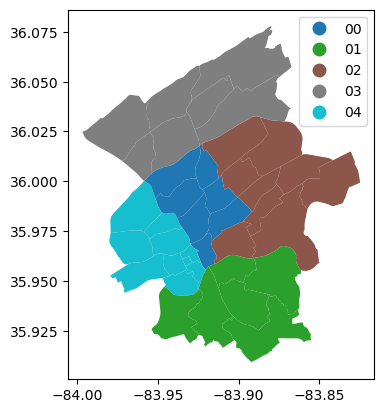

In [6]:
# preview supertracts
pup.geo.plot("super_trt", legend=True)

## Spatial Allocation with P-MEDM

### Create P-MEDM object

**Inputs:**

- ACS vintage year.
- The PUMS household response serial numbers (`serial`).
- The PUMS household sample weights (`wt`)
- Individual-level constraints (`est_ind`)
- Tract and block group level constraints (`est_trt`, `est_bg`)
- Tract and block group level standard errors (`se_trt`, `se_bg`)

In [7]:
pmd = PMEDM(
    pup.year,
    pup.est_ind.index,
    pup.wt,
    pup.est_ind,
    pup.est_g1,
    pup.est_g2,
    pup.se_g1,
    pup.se_g2,
    topo=pup.topo,
)

In [8]:
# Solve P-MEDM problem
pmd.solve()

In [9]:
# objective value
float(pmd.res.state.value)

-1.1279548985719166

### Diagnostics

As a quick diagnostic, we measure the proportion of synthetic constraint estimates fitting the ACS 90% margins of error (MOEs), or the "moe_fit_rate":

In [10]:
diagnostics.moe_fit_rate(pup.est_ind, pup.est_g2, pup.se_g2, pmd.almat)

{'Ycomp':                         constraint   acs        pmedm        err    moe  \
 47093000100             population  2650  2738.058875  88.058875  313.0   
 47093001700             population  2607  2684.180229  77.180229  392.0   
 47093001600             population  3441  3367.691781  73.308219  497.0   
 47093001500             population  3399  3383.823337  15.176663  523.0   
 47093002900             population  3533  3488.978670  44.021330  572.0   
 ...                            ...   ...          ...        ...    ...   
 47093002800  hht_nonfam_hhsize_7pm     0     0.995335   0.995335   14.0   
 47093002600  hht_nonfam_hhsize_7pm     0     1.917365   1.917365   14.0   
 47093006903  hht_nonfam_hhsize_7pm    22    32.628659  10.628659   36.0   
 47093001400  hht_nonfam_hhsize_7pm     0     0.000001   0.000001   14.0   
 47093007000  hht_nonfam_hhsize_7pm     0     0.002512   0.002512   14.0   
 
              in_moe  
 47093000100    True  
 47093001700    True  
 4709300

## Population Synthesis

Use Lovelace and Ballas' (2013) "Truncate, Replicate, Sample" method to create 30 realizations of the residential synthetic population:

In [11]:
hs = homesim.synthesize(
    pmd.almat,
    pup.est_ind,
    pup.est_g2,
    pup.sporder,
    random_state=int(pup.fips),
)
hs

,sim,geoid,count
h_id,,,
2019GQ0001260,0,47093000100,1
2019GQ0004171,0,47093000100,1
2019GQ0012722,0,47093000100,4
2019GQ0013655,0,47093000100,1
2019GQ0015912,0,47093000100,5
...,...,...,...
2023HU1423212,29,47093007000,1
2023HU1424730,29,47093007000,2
2023HU1442592,29,47093007000,1


## Application 1: Creating Agents for `actlike`

For this example, we'll focus on tabulating 10th grade public school students. We will identify matching person-level records from the PUMS by querying the Census Microdata API on two criteria:

- Public School Student {`SCH` : 2}
- Attending 10th Grade {`SCHG` : 12}

We set up our API query by separating these conditions with an `&`, as:

In [12]:
# API query
q1 = "SCH=2&SCHG=12"

In [13]:
seg1_extract = acs.extract_pums_segment_ids(p, "person", q1, year=2023)

Then, create the agents by merging the extract with our synthetic population (`hs`): 

In [14]:
seg1 = hs.merge(
    seg1_extract.loc[:, ["SERIALNO", "p_id"]], left_on="h_id", right_on="SERIALNO"
)

In [15]:
seg1

,sim,geoid,count,SERIALNO,p_id
0,0,47093000100,3,2021HU0944536,2021HU094453603
1,0,47093001700,2,2019HU0801911,2019HU080191103
2,0,47093001700,1,2020HU0089394,2020HU008939402
3,0,47093001700,1,2020HU0516217,2020HU051621703
4,0,47093001700,1,2020HU0516217,2020HU051621704
...,...,...,...,...,...
12404,29,47093007000,4,2022HU1198587,2022HU119858702
12405,29,47093007000,1,2022HU1399945,2022HU139994503
12406,29,47093007000,1,2023HU0446894,2023HU044689402
12407,29,47093007000,4,2023HU1297821,2023HU129782103


## Application 2: Tabulating Segments

Sometimes we require more specific criteria to select segments than what is available in our P-MEDM constraints (i.e., occupation class, NAICS code, hours worked). We can fetch additional PUMS variables related to the constraints from the Census Microdata API query and then link them to our synthetic populations.

For this example, we'll estimate the counts of full-time workers in K-12 schools, specifically:

- Employed full time and currently at work (`ESR == 1`)
- Working in elementary or secondary schools (`NAICSP == 6111`)
- In a preschool, kindergarten, primary, or secondary school teaching position (`{OCCP : [2300, 2310, 2320]}`)
- Working 40+ hours per week (`WKHP >= 40`)

Begin by generating the new API query:

In [16]:
q2 = "ESR=1&NAICSP=6111&OCCP=2300:2320&WKHP=40:999"

A `>=` operator does not seem to be availble for CMD API requests, so `40:999` is used in its place.

Now make the API extract:

In [17]:
seg2 = acs.extract_pums_segment_ids(p, "person", q2, year=2023, censusapikey=key)

This returns a DataFrame containing the household ID (`SERIALNO`) and household structure (`SPORDER`) for each matching respondent in the PUMS:

In [18]:
seg2

,SERIALNO,SPORDER,ESR,NAICSP,OCCP,WKHP,p_id
1,2019HU0097682,2,1,6111,2310,45,2019HU009768202
2,2019HU0289957,2,1,6111,0230,40,2019HU028995702
3,2019HU0447417,1,1,6111,2300,40,2019HU044741701
4,2019HU0561641,1,1,6111,2300,50,2019HU056164101
5,2019HU0598017,1,1,6111,2310,50,2019HU059801701
6,2019HU0691164,1,1,6111,2310,40,2019HU069116401
7,2019HU0803948,1,1,6111,2310,40,2019HU080394801
8,2019HU0859840,1,1,6111,2320,50,2019HU085984001
9,2019HU0936196,1,1,6111,2310,40,2019HU093619601
10,2019HU0936196,2,1,6111,2310,40,2019HU093619602


Tabulation:

In [19]:
tab_seg2 = est.tabulate_by_serial(hs, seg2["SERIALNO"], "person")

In [20]:
tab_seg2

sim  geoid      
0    47093000100    31
     47093000800    27
     47093001400     5
     47093001500    34
     47093001600    22
                    ..
29   47093006800    26
     47093006901     3
     47093006902     7
     47093006903    12
     47093007000    17
Length: 1128, dtype: int64

### 2a. Comparing Segment Estimates Across Census Areas

This estimation method is more suited for geodemographic classification.  We'll stick with our K-12 educator segment from the previous example here. 

A necessary first step is to **normalize the estimates** to effectively relate census areas. The normalization procedure estimates the _proportion_ of the segment within each block group.  

This one-liner generates the total block group population and household counts by simulation number:

In [21]:
totalpop = est.tabulate_by_count(hs, pup.est_ind["population"])

In [22]:
totalpop

sim  geoid      
0    47093000100    1300.298880
     47093000800    1910.482358
     47093000901     532.097222
     47093000902     700.026594
     47093001400    1090.526723
                       ...     
29   47093006800    2000.278397
     47093006901    1007.328067
     47093006902    1118.482782
     47093006903     861.020484
     47093007000    1364.413348
Name: population, Length: 1170, dtype: float64

With `totalpop` in hand, we can then normalize the estimates: 

In [23]:
prop_seg2 = est.to_prop(tab_seg2, totalpop)

In [24]:
prop_seg2

sim  geoid      
0    47093000100    0.023841
     47093000800    0.014133
     47093001400    0.004585
     47093001500    0.019165
     47093001600    0.011954
                      ...   
27   47093000901    0.000000
28   47093000901    0.000000
     47093000902    0.000000
29   47093000901    0.000000
     47093000902    0.000000
Length: 1170, dtype: float64

### 2b. Monte Carlo Estimation

When comparing census areas, it is often more convenient to use estimates that are one-to-one. To achieve this, we can use Monte Carlo estimation to aggregate the simulation-level estimates (as well as gauge uncertainty). 

To generate the Monte Carlo estimates:

In [25]:
mc_prop_seg2 = est.monte_carlo_estimate(prop_seg2)

In [26]:
mc_prop_seg2.head()

,est,se
geoid,,
47093000100,0.023855,0.000054
47093000800,0.014197,0.000053
47093000901,0.000000,0.000000
47093000902,0.000856,0.000711
47093001400,0.004572,0.000013


#### Example 3b: Mapping the Estimates

In [27]:
knox_trt = pup.geo

In [28]:
mc_prop_seg2.index.name = "GEOID"

In [29]:
knox_trt["mc_prop_seg2"] = match(knox_trt, mc_prop_seg2.est)

<Axes: >

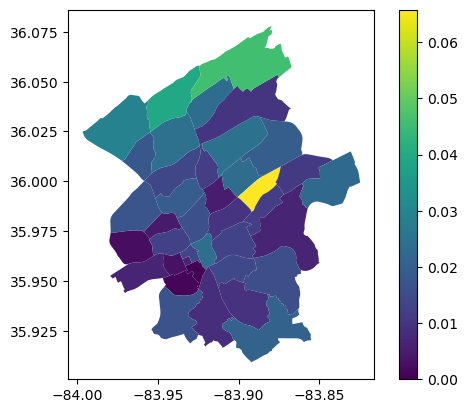

In [30]:
# plot!
knox_trt.plot(column="mc_prop_seg2", legend=True)